In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasRegressor
from tqdm.keras import TqdmCallback
from sklearn.inspection import permutation_importance
import optuna
import pickle
import warnings
warnings.filterwarnings('ignore')

optuna.logging.set_verbosity(optuna.logging.WARNING)

np.random.seed(1)
tf.random.set_seed(1)

# Neural Network Regression

Build and evaluate a neural network model for flight price prediction using TensorFlow/Keras.

This notebook uses a single, consistent hyperparameter optimization approach:
- Optuna (Bayesian Optimization) with TPE sampler and MedianPruner

Optuna optimizes the learning rate, batch size, and dropout rate for the same architecture, ensuring a unified workflow across models.

## Workflow Overview

- Define data and preprocessing (scaling selected continuous features)
- Optuna Bayesian Optimization (single tuner across the project)
- Final Training & Evaluation

We compute metrics (MAE, MSE, RMSE, R-Squared) on the original dollar scale after inverse log-transforming predictions.

## 1. Load Data

Same dataset as baselines for fair comparison.

In [2]:
df_train = pd.read_csv('data/train_data.csv')
df_test = pd.read_csv('data/test_data.csv')

**Feature-Target Separation**

Split features (X) and target (y = `baseFare`) for train and test.

In [3]:
X_train = df_train.drop(columns=['baseFare'])
y_train = df_train['baseFare']
X_test = df_test.drop(columns=['baseFare'])
y_test = df_test['baseFare']

print(f"Train: {len(X_train):,} rows, {X_train.shape[1]} features")
print(f"Test: {len(X_test):,} rows, {X_test.shape[1]} features")

Train: 125,668 rows, 49 features
Test: 31,418 rows, 49 features


## 2. Data Preparation

**Feature Scaling (StandardScaler)**

We scale only the continuous features that benefit from normalization:
- `seatsRemaining`
- `Booking Lead Time`
- `travelDuration_minutes`
- `departureTime_sin`
- `departureTime_cos`

All other features remain unscaled.

Fit `StandardScaler` on training data (learns mean/std), transform both train and test. We only fit on training data here because using test stats leaks information and inflates performance.

Scaling prevents vanishing/exploding gradients: extreme inputs make gradients approach zero or explode during backpropagation. Adam optimizes better with normalized inputs.

**Target Variable (baseFare)**

The `baseFare` column in the loaded CSV files is already log-transformed during preprocessing (see `01_Preprocessing.ipynb`). 

Therefore:
- We train the model directly on the log-transformed values.
- After prediction, we use `np.expm1()` to transform back to dollar amounts.

In [4]:
features_to_scale = ['seatsRemaining', 'Booking Lead Time', 'travelDuration_minutes', 'departureTime_sin', 'departureTime_cos']

scaler = StandardScaler()
scaler.fit(X_train[features_to_scale])

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[features_to_scale] = scaler.transform(X_train[features_to_scale])
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

X_train_scaled = X_train_scaled.values
X_test_scaled = X_test_scaled.values

## 3. Neural Network Architecture

The `create_model()` function builds a deep feed-forward neural network for predicting our **log-transformed** base fare.

**Architecture**
- **Input layer with all scaled features:** provides the model with normalized input data  
- **Dense layers:** capture complex non-linear feature interactions  
- **LeakyReLU (alpha = 0.1):** avoids dying ReLU neurons and improves gradient flow  
- **Batch Normalization:** stabilizes training and speeds up convergence  
- **Dropout:** reduces overfitting by randomly deactivating neurons  
- **He Normal initialization:** ensures proper weight scaling for ReLU/LeakyReLU activations  
- **Final output layer (1 neuron):** produces a single regression value (logarithmic base fare)  

**Training Setup**
- **Optimizer:** AdamW for adaptive learning with weight decay  
- **Loss Function:**  
  We use the **Huber loss**, which combines the smooth gradient behavior of MSE with the robustness of MAE.  
  This makes it well-suited for noisy flight price data containing outliers.  
- **Metrics:**  
  We log **MAE** during training because it is intuitive and later reported in dollar scale after inverse log-transform.  
  Importantly, **MAE is not the optimized loss**, it is only a monitoring metric.

**Consistency With Optuna (neg MSE)**
While Optuna uses **negative MSE** as the hyperparameter optimization objective, this does **not** need to match the training loss:

- The **training loss (Huber)** ensures stable and robust gradient-based learning.  
- The **Optuna scoring metric (neg MSE)** allows consistent and variance-stable comparison across hyperparameter settings.  
- The **training metric (MAE)** is logged purely for interpretability and does not affect optimization.

In [5]:
def create_model(learning_rate=0.0003, dropout_rate=0.4):

    model = keras.Sequential([
        layers.Input(shape=(X_train_scaled.shape[1],)),
        
        layers.Dense(1024, kernel_initializer='he_normal'),
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        
        layers.Dense(512, kernel_initializer='he_normal'),
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        
        layers.Dense(256, kernel_initializer='he_normal'),
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate * 0.8),
        
        layers.Dense(128, kernel_initializer='he_normal'),
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate * 0.8),
        
        layers.Dense(64, kernel_initializer='he_normal'),
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate * 0.6),
        
        layers.Dense(32, kernel_initializer='he_normal'),
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(dropout_rate * 0.4),
        
        layers.Dense(1)
    ])
    
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-5),
        loss='huber',
        metrics=['mae']
    )
    
    return model

## 4. Optuna Bayesian Optimization

Refine hyperparameters using Bayesian optimization. Optuna explores the space efficiently and can find better values between grid points.

Steps:
1. Define objective (5-fold CV, maximize negative MSE)
2. Create and run study (TPE + MedianPruner)
3. Train final NN using Optuna-best parameters

Objective: 5-fold CV maximizing negative MSE (i.e., better is closer to 0 from below)

## 5. Run Optuna Study

Execute the Optuna optimization with seeded TPE sampler and MedianPruner.

Define Optuna objective using 5-fold CV:

In [6]:
keras_cv = KerasRegressor(
    model=create_model,
    epochs=30,
    verbose=0,
)

def nn_objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)

    estimator = keras_cv.set_params(
        model__learning_rate=learning_rate,
        model__dropout_rate=dropout_rate,
        batch_size=batch_size,
    )

    scores = cross_val_score(
        estimator,
        X_train_scaled, y_train,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=1,
    )
    
    return float(np.mean(scores))

**Why 30 epochs for Optuna trials?**

- MedianPruner stops underperforming trials early to save time
- Good trials run long enough for robust comparison
- Goal: identify best hyperparameters; final model will be trained longer with early stopping

Create study and run optimization:

In [7]:
study_nn = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=1),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=0,
        interval_steps=1
    ),
)

Run study and report results:

In [8]:
study_nn.optimize(nn_objective, n_trials=50, timeout=None, show_progress_bar=True)

best_neg_mse = study_nn.best_value
best_mse = -best_neg_mse
best_rmse = np.sqrt(best_mse)

print("Optuna Best Parameters:")
print(study_nn.best_params)
print(f"Best CV neg-MSE (maximize): {best_neg_mse:.6f}")
print(f"Best CV MSE: {best_mse:.6f}")
print(f"Best CV RMSE: {best_rmse:.6f}")
print(f"Number of trials: {len(study_nn.trials)}")
print(f"Pruned trials: {len([t for t in study_nn.trials if t.state == optuna.trial.TrialState.PRUNED])}")
print(f"Completed trials: {len([t for t in study_nn.trials if t.state == optuna.trial.TrialState.COMPLETE])}")

Best trial: 45. Best value: -0.0541961: 100%|██████████| 50/50 [12:22:38<00:00, 891.16s/it]   

Optuna Best Parameters:
{'learning_rate': 0.0009985391099465281, 'batch_size': 128, 'dropout_rate': 0.21281154870107574}
Best CV neg-MSE (maximize): -0.054196
Best CV MSE: 0.054196
Best CV RMSE: 0.232801
Number of trials: 50
Pruned trials: 0
Completed trials: 50


## 6. Train Final Model with Optuna-Best Hyperparameters

Extract best hyperparameters from Optuna:

In [9]:
best_lr = study_nn.best_params['learning_rate']
best_batch_size = study_nn.best_params['batch_size']
best_dropout = study_nn.best_params['dropout_rate']

print(best_lr)
print(best_batch_size)
print(best_dropout)

0.0009985391099465281
128
0.21281154870107574


Train final model with Optuna-best params:

In [10]:
final_model = create_model(learning_rate=best_lr, dropout_rate=best_dropout)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    min_delta=1e-6
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=1e-6,
    verbose=1
)

tqdm_callback = TqdmCallback(verbose=1)

history = final_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=best_batch_size,
    callbacks=[early_stopping, reduce_lr, tqdm_callback],
    verbose=0
)

 31%|███       | 93/300 [06:14<13:46,  3.99s/epoch, loss=0.0203, mae=0.147, val_loss=0.0228, val_mae=0.139, learning_rate=0.000999]


Epoch 94: ReduceLROnPlateau reducing learning rate to 0.0004992695758119226.


 39%|███▉      | 117/300 [07:50<11:58,  3.93s/epoch, loss=0.0178, mae=0.138, val_loss=0.0223, val_mae=0.134, learning_rate=0.000499]


Epoch 118: ReduceLROnPlateau reducing learning rate to 0.0002496347879059613.


 44%|████▍     | 132/300 [08:50<11:11,  4.00s/epoch, loss=0.0164, mae=0.134, val_loss=0.0218, val_mae=0.132, learning_rate=0.00025] 


Epoch 133: ReduceLROnPlateau reducing learning rate to 0.00012481739395298064.


 51%|█████     | 153/300 [10:15<10:02,  4.10s/epoch, loss=0.0161, mae=0.132, val_loss=0.0219, val_mae=0.132, learning_rate=0.000125]


Epoch 154: ReduceLROnPlateau reducing learning rate to 6.240869697649032e-05.


 56%|█████▌    | 168/300 [11:16<09:01,  4.10s/epoch, loss=0.0156, mae=0.131, val_loss=0.0218, val_mae=0.132, learning_rate=6.24e-5] 


Epoch 169: ReduceLROnPlateau reducing learning rate to 3.120434848824516e-05.


 61%|██████    | 183/300 [12:17<08:04,  4.14s/epoch, loss=0.0156, mae=0.13, val_loss=0.0218, val_mae=0.132, learning_rate=3.12e-5] 


Epoch 184: ReduceLROnPlateau reducing learning rate to 1.560217424412258e-05.


 63%|██████▎   | 189/300 [12:42<07:27,  4.03s/epoch, loss=0.0154, mae=0.13, val_loss=0.0217, val_mae=0.132, learning_rate=1.56e-5] 


## 7. Visualize Training History

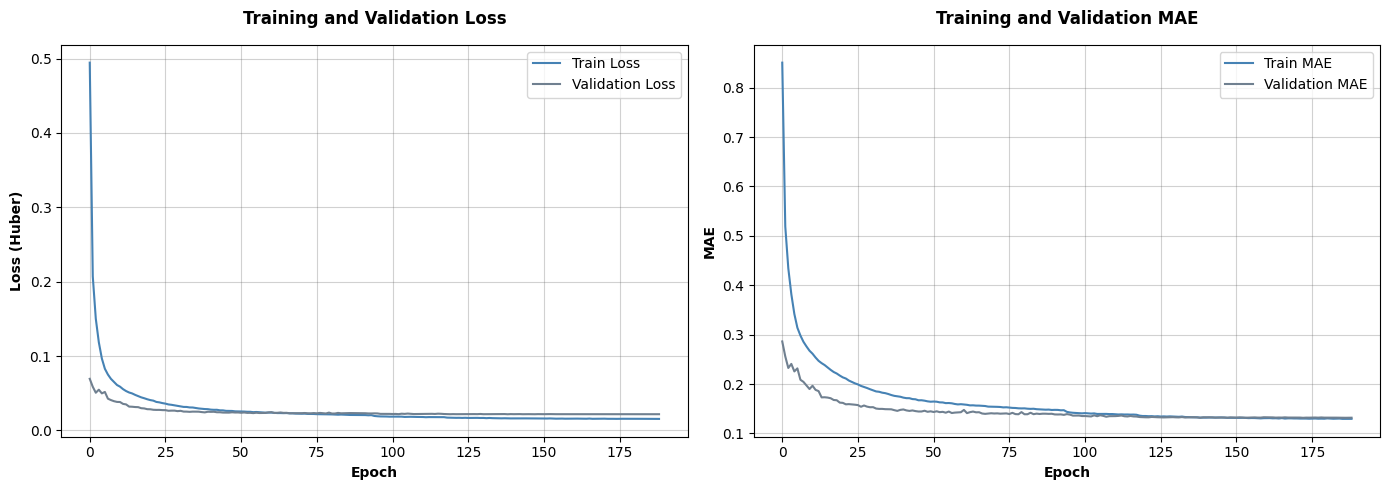

In [11]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='steelblue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='slategray')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss (Huber)', fontweight='bold')
plt.title('Training and Validation Loss', fontweight='bold', pad=15)
plt.legend()
plt.grid(True, alpha=0.3, color='dimgray')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', color='steelblue')
plt.plot(history.history['val_mae'], label='Validation MAE', color='slategray')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('MAE', fontweight='bold')
plt.title('Training and Validation MAE', fontweight='bold', pad=15)
plt.legend()
plt.grid(True, alpha=0.3, color='dimgray')

plt.tight_layout()
plt.show()

Healthy training because both losses decrease and converge, validation is close to training.

## 8. Evaluate on Test Set

Predict in log-space and then we use `np.expm1()` to transform back to dollars, therefore we calculate metrics on original scales.

In [12]:
y_pred_log = final_model.predict(X_test_scaled).flatten()
y_pred_nn = np.expm1(y_pred_log)

y_test_original = np.expm1(y_test)

982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step


Metrics (MAE, MSE, RMSE, R-Squared) are calculated on the original dollar scale for interpretability:

In [13]:
mae_nn = mean_absolute_error(y_test_original, y_pred_nn)
mse_nn = mean_squared_error(y_test_original, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_test_original, y_pred_nn)

print(f"MAE:  {mae_nn:.2f} $")
print(f"MSE:  {mse_nn:.2f} $")
print(f"RMSE: {rmse_nn:.2f} $")
print(f"R-Squared:   {r2_nn:.4f}")

MAE:  25.75 $
MSE:  3208.16 $
RMSE: 56.64 $
R-Squared:   0.7663


## 9. Error Analysis

Detailed analysis of prediction errors to understand model strengths and weaknesses.

### Calculate Prediction Errors

Compute absolute and relative errors for detailed analysis.

In [14]:
y_test_actual = np.expm1(y_test)
y_pred_actual = y_pred_nn

errors = y_pred_actual - y_test_actual
abs_errors = np.abs(errors)
relative_errors = (abs_errors / y_test_actual) * 100

error_df = pd.DataFrame({
    'actual': y_test_actual,
    'predicted': y_pred_actual,
    'error': errors,
    'abs_error': abs_errors,
    'relative_error_pct': relative_errors
})

### Prediction Range Check

First, verify that predictions and actuals are correctly transformed from log scale.

In [15]:
print(f"Actual fares ($):")
print(f"Min: {y_test_original.min():.2f} $")
print(f"Max: {y_test_original.max():.2f} $")
print(f"Mean: {y_test_original.mean():.2f} $")
print(f"Median: {y_test_original.median():.2f} $")

print(f"Predicted fares ($):")
print(f"Min: {y_pred_nn.min():.2f} $")
print(f"Max: {y_pred_nn.max():.2f} $")
print(f"Mean: {y_pred_nn.mean():.2f} $")
print(f"Median: {np.median(y_pred_nn):.2f} $")

print(f"Log-transformed predictions (before expm1):")
print(f"Min: {y_pred_log.min():.4f}")
print(f"Max: {y_pred_log.max():.4f}")
print(f"Mean: {y_pred_log.mean():.4f}")

Actual fares ($):
Min: 1.00 $
Max: 2976.74 $
Mean: 193.01 $
Median: 169.30 $
Predicted fares ($):
Min: -0.17 $
Max: 1328.15 $
Mean: 186.07 $
Median: 166.52 $
Log-transformed predictions (before expm1):
Min: -0.1890
Max: 7.1923
Mean: 5.0719


### Comprehensive Visualization: Predictions and Residuals

Three-panel visualization showing actual vs predicted, residuals, and residual distribution.

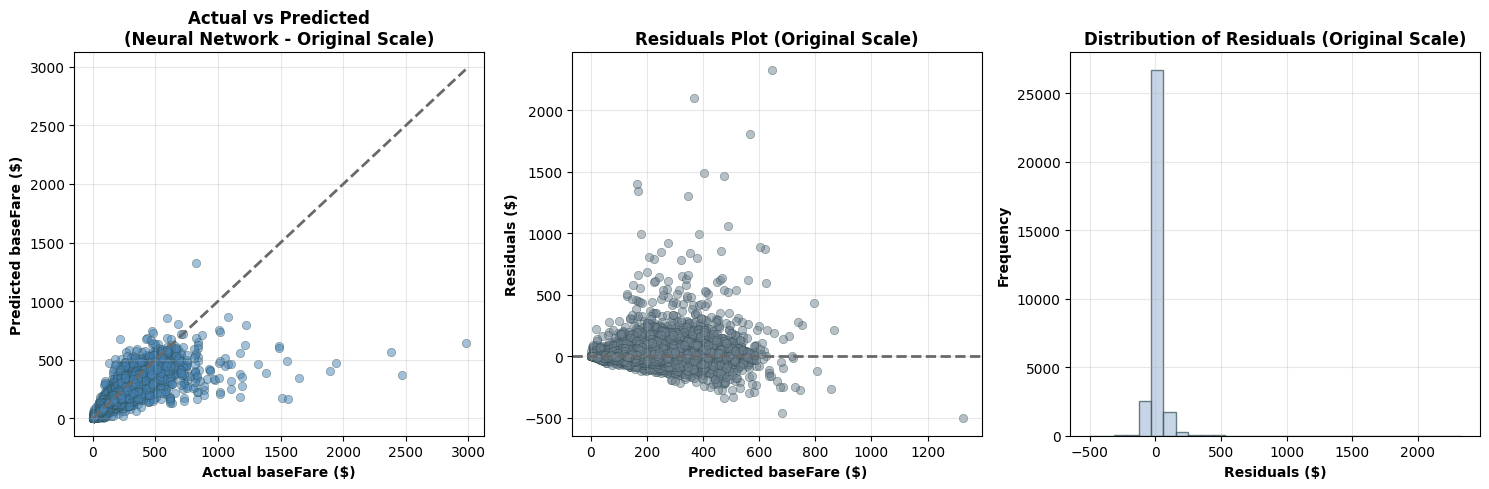

In [16]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test_actual, y_pred_actual, alpha=0.5, color='steelblue', edgecolors='darkslategray', linewidth=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()], '--', color='dimgray', lw=2)
plt.xlabel('Actual baseFare ($)', fontweight='bold')
plt.ylabel('Predicted baseFare ($)', fontweight='bold')
plt.title('Actual vs Predicted\n(Neural Network - Original Scale)', fontweight='bold', fontsize=12)
plt.grid(True, alpha=0.3)

residuals = y_test_actual - y_pred_actual
plt.subplot(1, 3, 2)
plt.scatter(y_pred_actual, residuals, alpha=0.5, color='slategray', edgecolors='darkslategray', linewidth=0.5)
plt.axhline(y=0, color='dimgray', linestyle='--', lw=2)
plt.xlabel('Predicted baseFare ($)', fontweight='bold')
plt.ylabel('Residuals ($)', fontweight='bold')
plt.title('Residuals Plot (Original Scale)', fontweight='bold', fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='darkslategray', color='lightsteelblue')
plt.xlabel('Residuals ($)', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.title('Distribution of Residuals (Original Scale)', fontweight='bold', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Analysis by Fare Range

Investigate how model performance varies across different price ranges.

Define fare ranges:

In [17]:
bins = [0, 100, 200, 300, 500, 1000, 3000]
labels = ['0-100 $', '100-200 $', '200-300 $', '300-500 $', '500-1000 $', '1000+ $']

error_df['fare_range'] = pd.cut(error_df['actual'], bins=bins, labels=labels)

Calculate metrics per range:

In [18]:
range_analysis = error_df.groupby('fare_range', observed=True).agg({
    'abs_error': ['mean', 'median', 'std'],
    'relative_error_pct': ['mean', 'median'],
    'actual': 'count'
}).round(2)

range_analysis.columns = ['MAE', 'Median_AE', 'Std_AE', 'Mean_Rel_%', 'Median_Rel_%', 'Count']

Performance by Fare Range:

In [19]:
range_analysis

,MAE,Median_AE,Std_AE,Mean_Rel_%,Median_Rel_%,Count
fare_range,,,,,,
0-100 $,11.61,6.72,14.56,22.51,10.83,5920
100-200 $,16.44,10.35,19.27,11.14,7.13,13162
200-300 $,28.47,20.36,28.70,11.76,8.55,7230
300-500 $,46.04,30.30,47.76,12.45,8.35,4642
500-1000 $,169.77,129.79,144.95,26.54,22.95,430
1000+ $,917.40,824.36,493.50,64.20,68.19,34


Visualization:

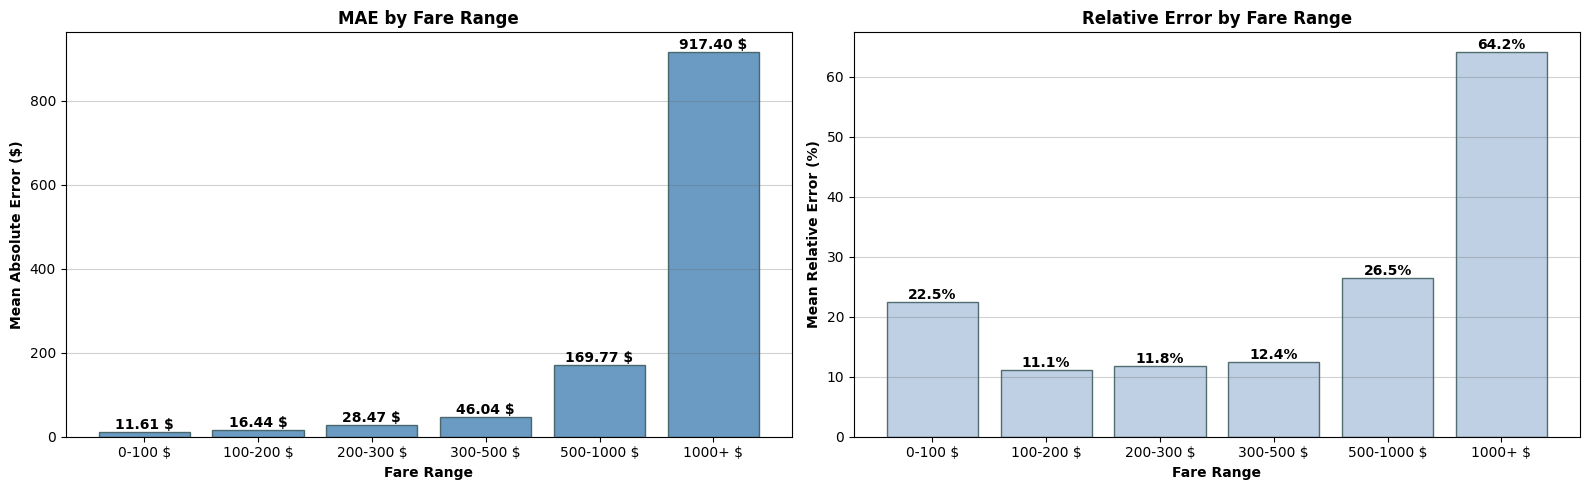

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].bar(range(len(range_analysis)), range_analysis['MAE'],
            color='steelblue', edgecolor='darkslategray', alpha=0.8)
axes[0].set_xticks(range(len(range_analysis)))
axes[0].set_xticklabels(range_analysis.index, rotation=0)
axes[0].set_ylabel('Mean Absolute Error ($)', fontweight='bold')
axes[0].set_xlabel('Fare Range', fontweight='bold')
axes[0].set_title('MAE by Fare Range', fontweight='bold', fontsize=12)
axes[0].grid(axis='y', alpha=0.3, color='dimgray')

for i, v in enumerate(range_analysis['MAE']):
    axes[0].text(i, v, f'{v:.2f} $', ha='center', va='bottom', fontweight='bold')

axes[1].bar(range(len(range_analysis)), range_analysis['Mean_Rel_%'],
            color='lightsteelblue', edgecolor='darkslategray', alpha=0.8)
axes[1].set_xticks(range(len(range_analysis)))
axes[1].set_xticklabels(range_analysis.index, rotation=0)
axes[1].set_ylabel('Mean Relative Error (%)', fontweight='bold')
axes[1].set_xlabel('Fare Range', fontweight='bold')
axes[1].set_title('Relative Error by Fare Range', fontweight='bold', fontsize=12)
axes[1].grid(axis='y', alpha=0.3, color='dimgray')

for i, v in enumerate(range_analysis['Mean_Rel_%']):
    axes[1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Worst Predictions Analysis

Identify and analyze the cases where the model performs worst. Top 10 worst results here.

In [21]:
worst_10 = error_df.nlargest(10, 'abs_error')[['error', 'actual', 'predicted']]

worst_10

,error,actual,predicted
26233,-2331.467661,2976.74,645.272339
774,-2100.033322,2467.91,367.876678
17750,-1810.221453,2377.67,567.448547
1689,-1490.775829,1893.02,402.244171
29395,-1463.925012,1938.60,474.674988
28578,-1397.178085,1561.86,164.681915
23645,-1341.912250,1510.70,168.787750
7432,-1300.248678,1646.51,346.261322
29864,-1059.250454,1547.91,488.659546
3311,-996.288575,1174.89,178.601425


## 10. Feature Importance Analysis

Analyze which features contribute most to the Neural Network's prediction decisions using permutation importance.

982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 573us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 580us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 574us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 578us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 578us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 574us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 578us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 590us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 572us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 616us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 574us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 593us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step
982/982 ━━━

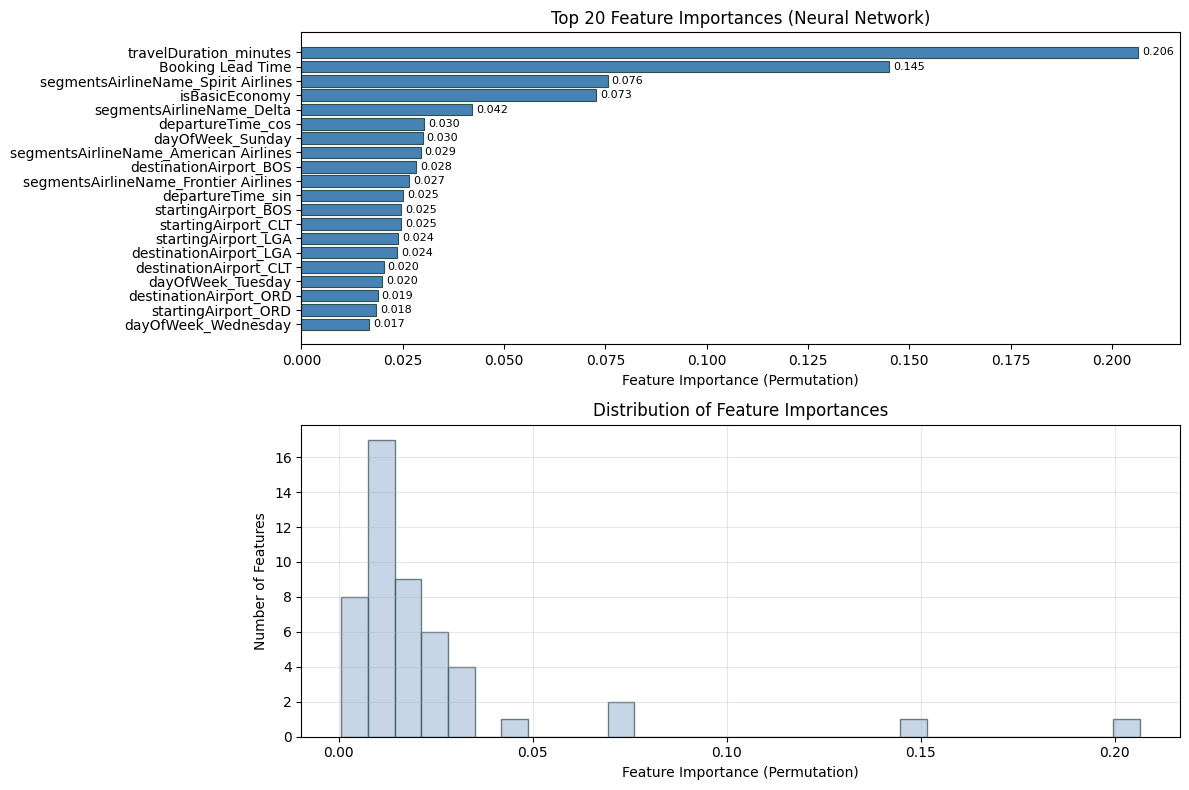

In [22]:
feature_names = X_train.columns

result = permutation_importance(
    estimator=final_model,         
    X=X_test_scaled,               
    y=y_test,                     
    n_repeats=10,
    random_state=1,
    scoring='neg_mean_absolute_error'
)

importances = result.importances_mean


importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
top_features = importance_df.head(20)

bars = plt.barh(
    range(len(top_features)),
    top_features['Importance'],
    color='steelblue',
    edgecolor='darkslategray',
    linewidth=0.8
)

plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance (Permutation)')
plt.title('Top 20 Feature Importances (Neural Network)')
plt.gca().invert_yaxis()

for i, bar in enumerate(bars):
    w = bar.get_width()
    plt.text(w + 0.001, bar.get_y() + bar.get_height()/2,
             f'{w:.3f}', ha='left', va='center', fontsize=8)

plt.subplot(2, 1, 2)
plt.hist(importances, bins=30, alpha=0.7,
         color='lightsteelblue', edgecolor='darkslategray')
plt.xlabel('Feature Importance (Permutation)')
plt.ylabel('Number of Features')
plt.title('Distribution of Feature Importances')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Export Models

Save Neural Network

In [23]:
final_model.save("models/neural_network.keras")

Save Scaler

In [24]:
with open("models/scaler/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)